See the O$_2$sclpy documentation at https://awsteiner.org/code/o2sclpy for more information.

In [1]:
import o2sclpy
import matplotlib.pyplot as plot
import numpy
import sys

plots=True
if 'pytest' in sys.modules:
    plots=False

Load the data sets of nuclei

Instantiate and load the Atomic Mass Evaluation. The third parameter
is False, to indicate that we include masses which are not solely
determined by experiment

In [2]:
ame=o2sclpy.nucmass_ame()
ame.load('20',False)
print('Number of isotopes in the AME list:',ame.get_nentries())

Number of isotopes in the AME list: 3558


In [3]:
dist_exp=o2sclpy.std_vector_nucleus()
o2sclpy.nucdist_set(dist_exp,ame)
print('Number of nuclei in dist_exp:',len(dist_exp))

Number of nuclei in dist_exp: 3557


In [4]:
msis=o2sclpy.nucmass_mnmsk()
o2sclpy.mnmsk_load(msis,'msis16')

In [5]:
dist_msis=o2sclpy.std_vector_nucleus()
o2sclpy.nucdist_set(dist_msis,msis)
print('Number of nuclei in dist_msis:',len(dist_msis))

Number of nuclei in dist_msis: 9318


Instantiate the Duflo-Zuker (DZ) fit and set parameters from a
recent fit. Note that this isn't the original DZ table, but rather a
new fit of the 33-parameter DZ model to the 2020 AME.

In [6]:
dz=o2sclpy.nucmass_dz_fit_33()
p=o2sclpy.ublas_vector()
p.resize(33)
p[0]=9.089056134746128e+00
p[1]=6.503243633083565e+00
p[2]=4.508165895514288e+00
p[3]=2.078535386636489e+01
p[4]=1.725739163595326e+00
p[5]=7.535149383516492e+00
p[6]=-4.506924382606631e+00
p[7]=-3.412765813834761e+01
p[8]=-3.585539147281765e-01
p[9]=7.344223304154160e-01
p[10]=-7.511052798991504e-01
p[11]=-3.761406531766877e+00
p[12]=-1.776599459045521e-01
p[13]=-8.995089717699093e-01
p[14]=3.973338204326113e-01
p[15]=1.807250910019584e+00
p[16]=2.413813645058122e-01
p[17]=1.066620521567073e+00
p[18]=8.518733677001322e+00
p[19]=5.373696129291158e+01
p[20]=1.824339588062157e+01
p[21]=7.270593853877729e+01
p[22]=-2.714335458881215e+01
p[23]=-1.284192451766697e+02
p[24]=-5.001066637985519e+00
p[25]=-3.299700362463194e+01
p[26]=-3.794286672329046e+01
p[27]=-5.392723600204433e+01
p[28]=1.559715229007208e+00
p[29]=5.448044100904870e+00
p[30]=7.054620573104972e-01
p[31]=6.182687849301996e+00
p[32]=2.076508980189957e+01
dz.fit_fun(33,p)

0

Instantiate the FRDM fit and set parameters from a recent fit

In [7]:
frdm=o2sclpy.nucmass_frdm()
p.resize(10)
p[0]=1.470521168091704e+00
p[1]=1.110599542324431e+00
p[2]=4.233650770523403e+01
p[3]=1.677705218132046e+01
p[4]=2.646289872432062e+01
p[5]=3.443846328788821e+01
p[6]=2.585455547917483e+01
p[7]=7.138147608954237e-01
p[8]=1.284100176024626e+00
p[9]=2.660955290904157e-01
frdm.fit_fun(10,p)

0

Instantiate tables

In [8]:
wlw=o2sclpy.nucmass_wlw()
wlw.load("WS4_RBF")

0

Create the initial table from which the neural network fit is based
We fit the deviation in the mass excess. We also remove the
most neutron-rich isotopes of Sn by hand, so we can see how good
the neural network is doing later.

In [9]:
nuc=o2sclpy.nucleus()
tab=o2sclpy.table()
tab.line_of_names('Z N mex mex_th diff')
for Z in range(8,200):
    for N in range(8,250):
        line=[Z,N,0,0,0]
        if (ame.is_included(Z,N) and dz.is_included(Z,N) and
            (Z!=50 or N<=80)):
            ame.get_nucleus(Z,N,nuc)
            line[2]=nuc.mex*197.33
            dz.get_nucleus(Z,N,nuc)
            line[3]=nuc.mex*197.33
            line[4]=line[2]-line[3]
            if Z==50:
                print(line)
            tab.line_of_data(line)

[50, 49, -47.97673413926554, -47.124472360994325, -0.8522617782712132]
[50, 50, -57.149020493453634, -56.35209247901923, -0.7969280144344069]
[50, 51, -60.30654680987393, -59.59904678979571, -0.7075000200782213]
[50, 52, -64.93588964800853, -64.92505378613309, -0.010835861875435171]
[50, 53, -67.09302665648664, -67.32853090433862, 0.23550424785197777]
[50, 54, -71.62815305292268, -71.98152311680884, 0.3533700638861603]
[50, 55, -73.33912323416271, -73.80410675943384, 0.46498352527112274]
[50, 56, -77.35488168323822, -77.83791589429518, 0.4830342110569603]
[50, 57, -78.51344041148649, -79.12535309732084, 0.6119126858343549]
[50, 58, -82.07120485234454, -82.58511365215891, 0.5139087998143737]
[50, 59, -82.63144442512207, -83.37550862271732, 0.7440641975952502]
[50, 60, -85.84330657298844, -86.29907953321292, 0.4557729602244791]
[50, 61, -85.9398960509992, -86.62413945996235, 0.6842434089631553]
[50, 62, -88.65640561898782, -89.04325948971726, 0.3868538707294391]
[50, 63, -88.329480616386

Write the table to a file

In [10]:
hf=o2sclpy.hdf_file()
hf.open_or_create('nm2.o2')
o2sclpy.hdf_output_table(hf,tab,b'table')
hf.close()

Reformat the table into a numpy array for the interpm class

In [11]:
N=tab.get_nlines()
x2=numpy.zeros((N,2))
y2=numpy.zeros((N,1))
for i in range(0,N):
    x2[i,0]=tab["Z"][i]
    x2[i,1]=tab["N"][i]
    y2[i,0]=tab["diff"][i]
print('Number of isotopes to fit:',N)

Number of isotopes to fit: 3446


The input transformation

In [12]:
trans='moto'

The activation function

In [13]:
act='relu'

The neural network size parameter

In [14]:
M=4

Create the neural network interpolation object

In [15]:
im2=o2sclpy.interpm_tf_dnn()

Train the neural network or load a previous training

In [16]:
if True:
    im2.set_data(x2,y2,verbose=1,epochs=800,
                 transform_in=trans,test_size=0.1,
                 activations=[act,act,act,act],
                 hlayers=[240*M,120*M,60*M,40*M])
else:
    im2.load('nucmass_nn')

2025-06-13 03:35:17.371806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749785717.384882    1844 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749785717.389190    1844 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749785717.401845    1844 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749785717.401861    1844 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749785717.401862    1844 computation_placer.cc:177] computation placer alr

interpm_tf_dnn::set_data():
  outformat: numpy
  in_data shape: (3446, 2)
  out_data shape: (3446, 1)
  batch_size: None
  layers: [960, 480, 240, 160]
  activation functions: ['relu', 'relu', 'relu', 'relu']
  transform_in: moto
  transform_out: none
  epochs: 800
  test_size: 0.1
min,max before transformation: -3.515548e+00 3.286357e+00
min,max after transformation : -3.515548e+00 3.286357e+00
nd_in,nd_out: 2 1
  Training DNN model.
Layer: dense 960 2 relu
Layer: dense 480 relu
Layer: dense 240 relu
Layer: dense 160 relu
Layer: dense 1 linear


I0000 00:00:1749785718.809386    1844 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18325 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:00:02.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 960)            │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 480)            │       461,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 240)            │       115,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        38,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,321 (2.36 MB)

 Trainable params: 618,321 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

summary: None
Epoch 1/800


I0000 00:00:1749785720.418574  125291 service.cc:152] XLA service 0x77e2a000b810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749785720.418605  125291 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
I0000 00:00:1749785720.557070  125291 cuda_dnn.cc:529] Loaded cuDNN version 90501


93/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2666

I0000 00:00:1749785724.264056  125291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.2665 - val_loss: 0.2398
Epoch 2/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2648 - val_loss: 0.2272
Epoch 3/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2495 - val_loss: 0.2231
Epoch 4/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2457 - val_loss: 0.2095
Epoch 5/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2346 - val_loss: 0.2024
Epoch 6/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2253 - val_loss: 0.1950
Epoch 7/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2161 - val_loss: 0.1986
Epoch 8/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1996 - val_loss: 0.1864
Epoch 9/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1985 - val_loss: 0.1850
Epoch 10/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2067 - val_loss: 0.1834
Epoch 11/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2057 - val_loss: 0.1794
Epoch 12/800
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1842 - val_

Print the absolute deviation

In [17]:
sum=0
for i in range(0,N):
    v=numpy.array([x2[i,0],x2[i,1]])
    sum+=numpy.abs(im2.eval(v)[0]-y2[i,0])
qual=sum/N
print('Quality: %7.6e' %(qual))

Quality: 1.296246e-01


Save the result in a file

In [18]:
im2.save('nucmass_nn')

Plot the loss and the validation loss

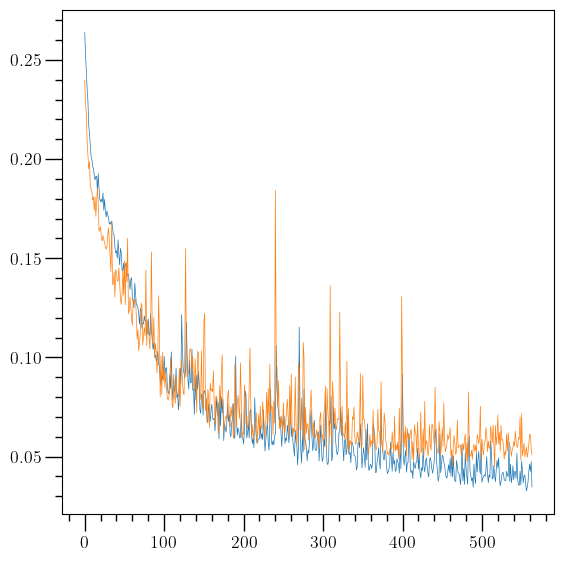

In [26]:
if plots:
    index=[i for i in range(0,len(im2.loss))]
    pb=o2sclpy.plot_base()
    pb.fig_dict='fig_size_x=6,fig_size_y=6,dpi=250'
    pb.plot([index,im2.loss])
    pb.plot([index,im2.val_loss])
    pb.show()
    plot.close()

Compute Tin isotopes

In [20]:
Z=50
sn=o2sclpy.table()
sn.line_of_names('N ame dz msis dz_nn dz_ame dz_nn_ame')
for N in range(50,100):
    if ame.is_included(Z,N):
        ame.get_nucleus(Z,N,nuc)
        ame_mex=nuc.mex
    else:
        ame_mex=0.0
    dz.get_nucleus(Z,N,nuc)
    dz_mex=nuc.mex
    msis.get_nucleus(Z,N,nuc)
    msis_mex=nuc.mex
    # diff is ame-dz, so ame is diff+dz
    ii=numpy.array([50,N])
    if ame.is_included(Z,N):
        line=[N,ame_mex*197.33,dz_mex*197.33,msis_mex*197.33,
              dz_mex*197.33+im2.eval(ii)[0],
              (dz_mex-ame_mex)*197.33,
              dz_mex*197.33+im2.eval(ii)[0]-ame_mex*197.33]
              
    else:
        line=[N,ame_mex*197.33,dz_mex*197.33,msis_mex*197.33,
              dz_mex*197.33+im2.eval(ii)[0],1.0,1.0]
    sn.line_of_data(line)

Plot Sn isotopes

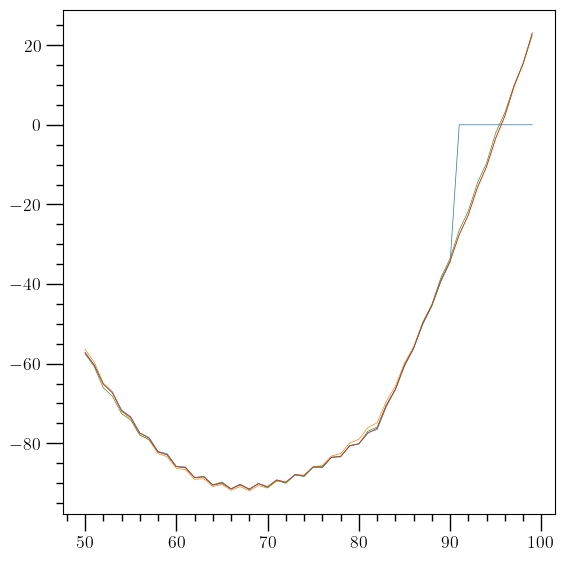

In [24]:
if plots:
    pb=o2sclpy.plot_base()
    pb.fig_dict='fig_size_x=6,fig_size_y=6,dpi=250'
    pb.plot([sn,'N','ame'])
    pb.plot([sn,'N','dz'])
    pb.plot([sn,'N','msis'])
    pb.plot([sn,'N','dz_nn'])
    pb.show()
    plot.close()

Plot theory minus experiment

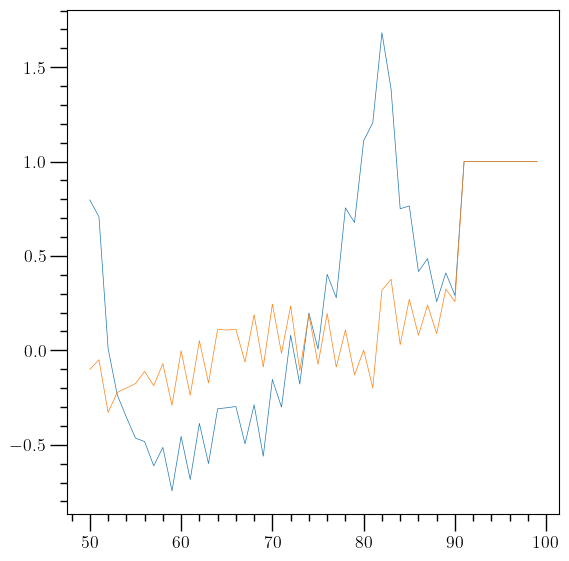

In [25]:
if plots:
    pb=o2sclpy.plot_base()
    pb.fig_dict='fig_size_x=6,fig_size_y=6,dpi=250'
    pb.plot([sn,'N','dz_ame'])
    pb.plot([sn,'N','dz_nn_ame'])
    pb.show()
    plot.close()